### Importação das Bibliotecas

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scikeras.wrappers import KerasRegressor

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

In [11]:
def create_sequences_mult(X, y, seq_len=14):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])   
        ys.append(y[i+seq_len])    
    return np.array(Xs), np.array(ys)

In [12]:
def create_lstm_model(seq_len=14, n_features=1, neurons=100, drop=0.2, optimizer='Adam'):
  model = Sequential([
      Input(shape=(seq_len, n_features)),
      LSTM(neurons, return_sequences=True),
      Dropout(drop),
      LSTM((neurons//2), return_sequences=False),
      Dropout(drop),
      Dense(1),
  ])
  model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
  return model


param_grid = {
                # 'model__neurons': [16, 32, 64],
                # 'model__drop': [0.1, 0.2, 0.3],
                # 'model__optimizer': ['Adam'], 
                # 'fit__batch_size': [16, 32],   
                # 'fit__epochs': [50, 100],
                'model__neurons': [40, 60],
                'model__drop': [0.1, 0.2],
                'model__optimizer': ['Adam'], 
                'fit__batch_size': [16],   
                'fit__epochs': [100],
              }

In [13]:
models_lstm_all = []
models_lstm_cropped = []
models_lstm_crypto_all = []
models_lstm_crypto_cropped = []
# seq_len_options = [7, 14, 30]
seq_len_options = [7, 30]
# split_options = [5, 10]
split_options = [5, 10]


event_date = pd.Timestamp('2024-11-05') 
event_label = "Trump Elected"

### Modelo com dado completo

In [134]:
data = pd.read_csv('../data/processed/BTC-USD_all.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [135]:
X_mult = data[['High', 'Low', 'Open', 'Volume']]
y_mult = data[['Close']]

In [136]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult.values, y_mult.values, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_raw, X_test_raw = X_seq[:train_size], X_seq[train_size:]
  y_train_raw, y_test_raw = y_seq[:train_size], y_seq[train_size:]

  scaler_X_all = MinMaxScaler(feature_range=(0, 1))
  scaler_y_all = MinMaxScaler(feature_range=(0, 1))

  # O X é 3D (samples, timesteps, features), então precisamos achatar para escalar
  X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2])
  X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])

  scaler_X_all.fit(X_train_reshaped)
  X_train_scaled = scaler_X_all.transform(X_train_reshaped).reshape(X_train_raw.shape)
  X_test_scaled = scaler_X_all.transform(X_test_reshaped).reshape(X_test_raw.shape)

  scaler_y_all.fit(y_train_raw)     
  y_train_scaled = scaler_y_all.transform(y_train_raw)
  y_test_scaled = scaler_y_all.transform(y_test_raw)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_all = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_all.append({
      "model": grid_result_all.best_estimator_,
      "params": grid_result_all.best_params_,
      "rmse": -grid_result_all.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Multivariado",
      "algorithm": "LSTM",
      "scaler_X": scaler_X_all,
      "scaler_y": scaler_y_all
    })
    
    print(f"Menor RMSE: {-grid_result_all.best_score_:.3f} usando: {grid_result_all.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.021 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.020 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.023 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 40, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.021 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 40, 'model__optimizer': 'Adam'}


#### Resultados


In [137]:
for m in models_lstm_all:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_all_ordered_by_test = sorted(models_lstm_all, key=lambda x: x["rmse_test"])
lstm_all_ordered_by_test

[{'model': KerasRegressor(
  	model=<function create_lstm_model at 0x000001BA1C852AC0>
  	build_fn=None
  	warm_start=False
  	random_state=None
  	optimizer=rmsprop
  	loss=None
  	metrics=None
  	batch_size=None
  	validation_batch_size=None
  	verbose=0
  	callbacks=None
  	validation_split=0.0
  	shuffle=True
  	run_eagerly=False
  	epochs=1
  	seq_len=7
  	n_features=4
  	fit__batch_size=16
  	fit__epochs=100
  	model__drop=0.2
  	model__neurons=60
  	model__optimizer=Adam
  ),
  'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.2,
   'model__neurons': 60,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.021397024850946807),
  'n_splits': 5,
  'seq_len': 7,
  'X_test': array([[[0.4255761 , 0.43939606, 0.43255635, 0.05125247],
          [0.42625163, 0.43630495, 0.43311515, 0.06863783],
          [0.42693265, 0.43739354, 0.43194585, 0.09220947],
          ...,
          [0.43419629, 0.43459839, 0.43826638, 0.15200957],
          [0.42526789, 0.434794

In [138]:
y_pred_scaled = lstm_all_ordered_by_test[0]["model"].predict(lstm_all_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_all_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_all_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = lstm_all_ordered_by_test[0]["scaler_y"].inverse_transform(y_pred_scaled)
y_test = lstm_all_ordered_by_test[0]["scaler_y"].inverse_transform(lstm_all_ordered_by_test[0]["y_test"])

MAE normalizado: 0.12348343219015888
RMSE normalizado: 0.1787241468948436


In [139]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 8321.392472029322
RMSE real: 12043.994376972154
MAPE: 8.87%
R²: 0.82


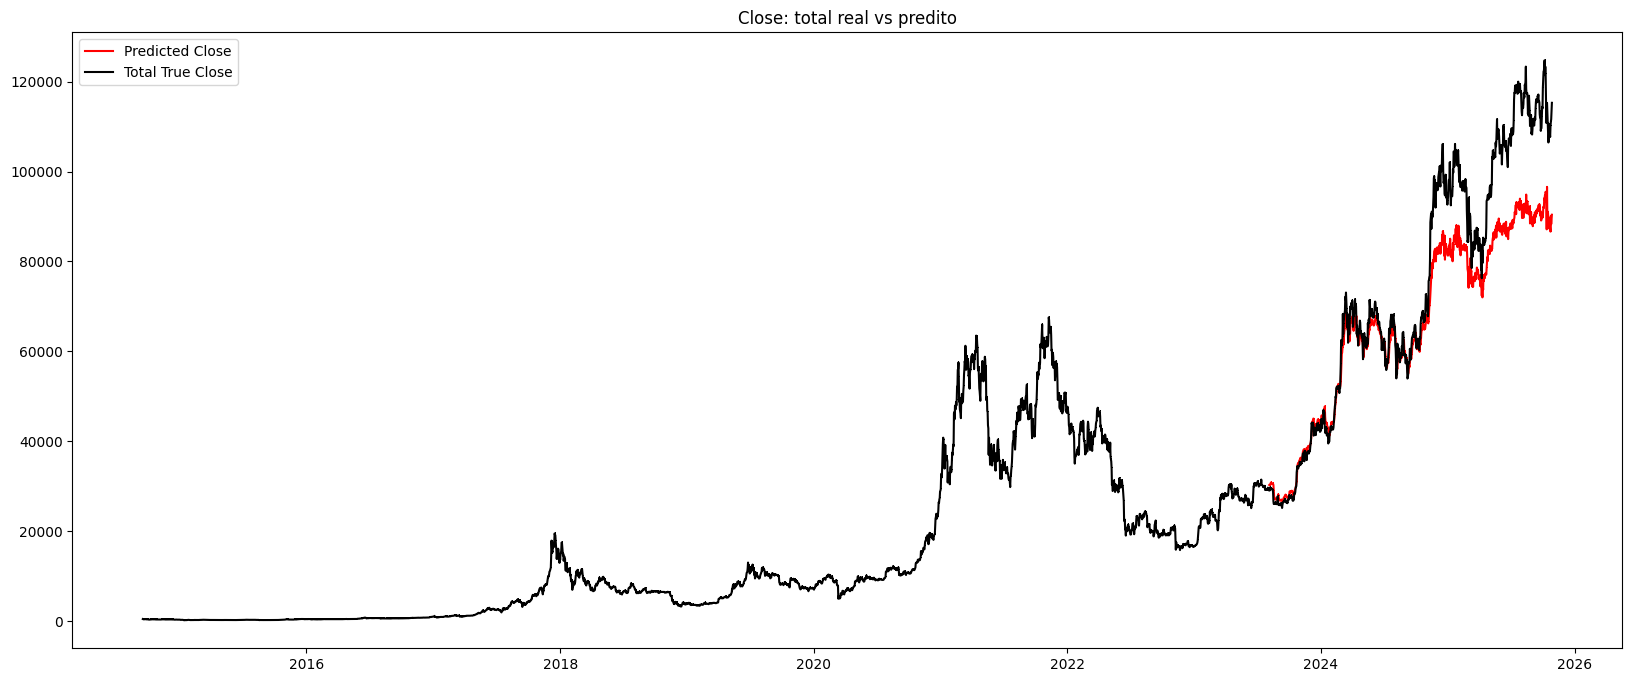

In [140]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

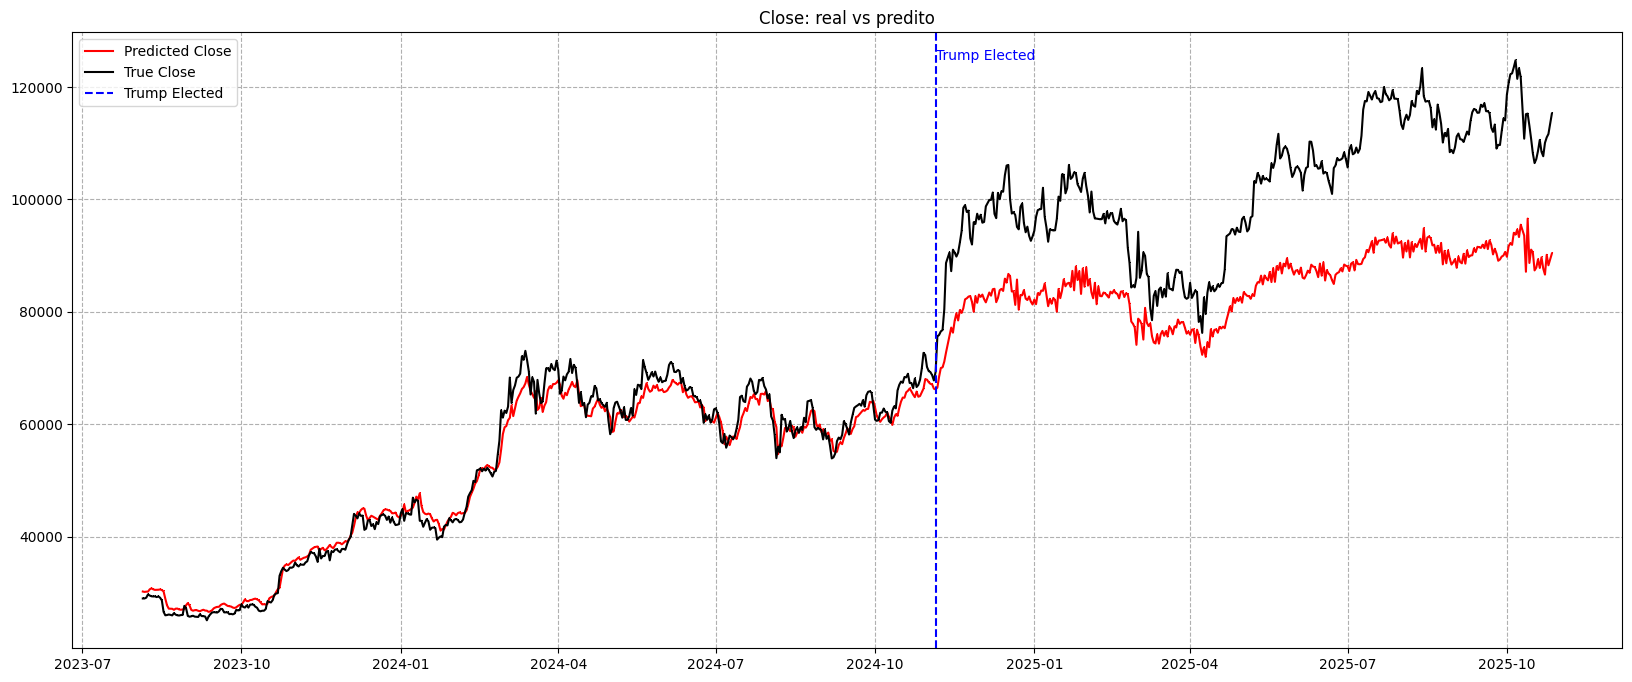

In [141]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

### Modelo com dado cortado (inicio ate a moeda se estabilizar foi removido)

In [142]:
data = pd.read_csv('../data/processed/BTC-USD_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008
2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992
2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000
2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984
2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008


In [143]:
X_mult = data[['High', 'Low', 'Open', 'Volume']]
y_mult = data[['Close']]

In [144]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult.values, y_mult.values, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_raw, X_test_raw = X_seq[:train_size], X_seq[train_size:]
  y_train_raw, y_test_raw = y_seq[:train_size], y_seq[train_size:]

  scaler_X_cropped = MinMaxScaler(feature_range=(0, 1))
  scaler_y_cropped = MinMaxScaler(feature_range=(0, 1))

  # O X é 3D (samples, timesteps, features), então precisamos achatar para escalar
  X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2])
  X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])

  scaler_X_cropped.fit(X_train_reshaped)
  X_train_scaled = scaler_X_cropped.transform(X_train_reshaped).reshape(X_train_raw.shape)
  X_test_scaled = scaler_X_cropped.transform(X_test_reshaped).reshape(X_test_raw.shape)

  scaler_y_cropped.fit(y_train_raw)     
  y_train_scaled = scaler_y_cropped.transform(y_train_raw)
  y_test_scaled = scaler_y_cropped.transform(y_test_raw)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_cropped = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_cropped.append({
      "model": grid_result_cropped.best_estimator_,
      "params": grid_result_cropped.best_params_,
      "rmse": -grid_result_cropped.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Multivariado",
      "algorithm": "LSTM",
      "scaler_X": scaler_X_cropped,
      "scaler_y": scaler_y_cropped
    })
    
    print(f"Menor RMSE: {-grid_result_cropped.best_score_:.3f} usando: {grid_result_cropped.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.030 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.022 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.033 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.027 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}


#### Resultados


In [145]:

for m in models_lstm_cropped:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_cropped_ordered_by_test = sorted(models_lstm_cropped, key=lambda x: x["rmse_test"])
lstm_cropped_ordered_by_test

[{'model': KerasRegressor(
  	model=<function create_lstm_model at 0x000001BA1C852AC0>
  	build_fn=None
  	warm_start=False
  	random_state=None
  	optimizer=rmsprop
  	loss=None
  	metrics=None
  	batch_size=None
  	validation_batch_size=None
  	verbose=0
  	callbacks=None
  	validation_split=0.0
  	shuffle=True
  	run_eagerly=False
  	epochs=1
  	seq_len=7
  	n_features=4
  	fit__batch_size=16
  	fit__epochs=100
  	model__drop=0.2
  	model__neurons=60
  	model__optimizer=Adam
  ),
  'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.2,
   'model__neurons': 60,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.021943876497693224),
  'n_splits': 10,
  'seq_len': 7,
  'X_test': array([[[0.62400545, 0.63554374, 0.62934551, 0.16264019],
          [0.62151801, 0.62427492, 0.62998672, 0.13824987],
          [0.62525699, 0.62398243, 0.61310611, 0.17624588],
          ...,
          [0.62334675, 0.63135585, 0.63432729, 0.16461468],
          [0.61873354, 0.60761

In [146]:
y_pred_scaled = lstm_cropped_ordered_by_test[0]["model"].predict(lstm_cropped_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_cropped_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_cropped_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = lstm_cropped_ordered_by_test[0]["scaler_y"].inverse_transform(y_pred_scaled)
y_test = lstm_cropped_ordered_by_test[0]["scaler_y"].inverse_transform(lstm_cropped_ordered_by_test[0]["y_test"])

MAE normalizado: 0.04132940760539246
RMSE normalizado: 0.05346859490583268


In [147]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 2760.3527611468066
RMSE real: 3571.1176324582516
MAPE: 3.21%
R²: 0.97


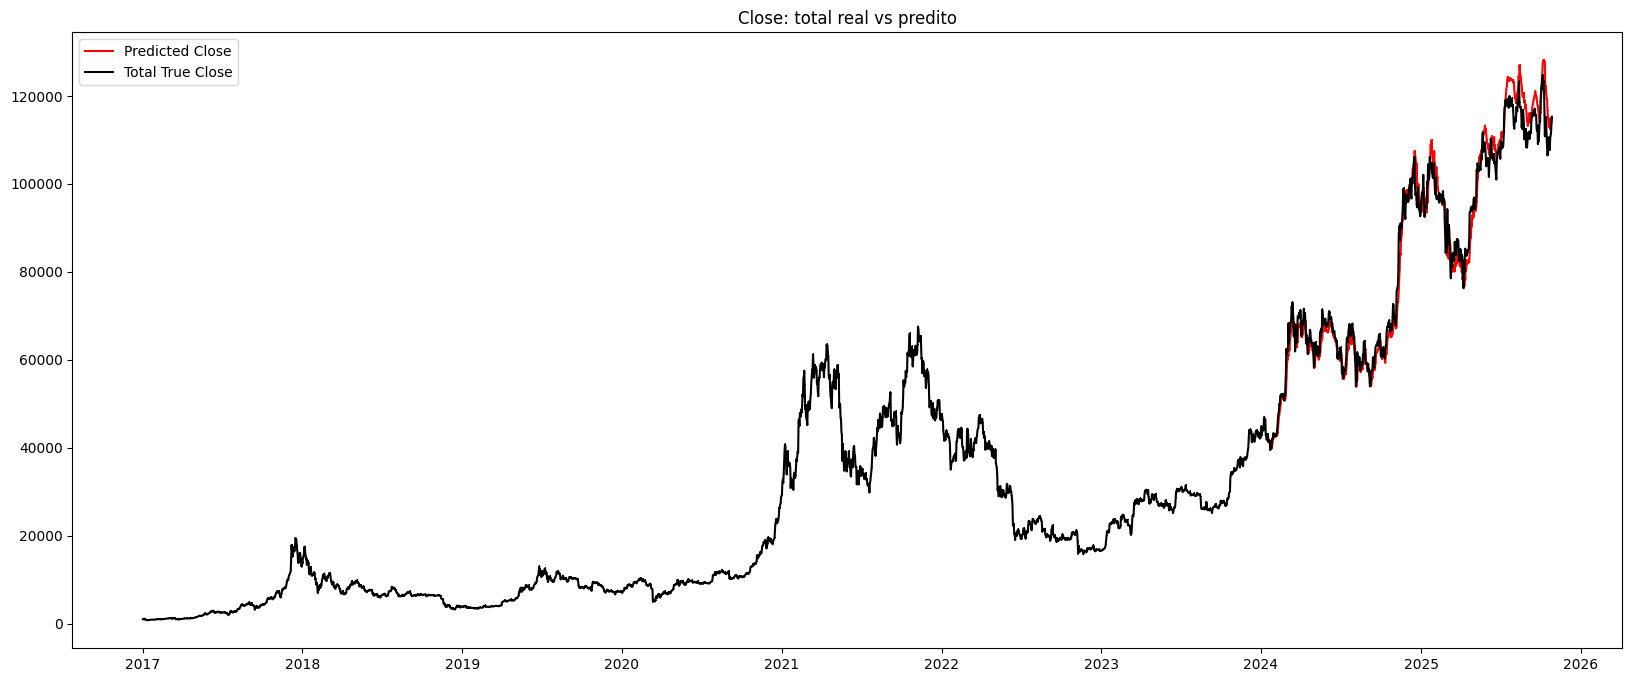

In [148]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

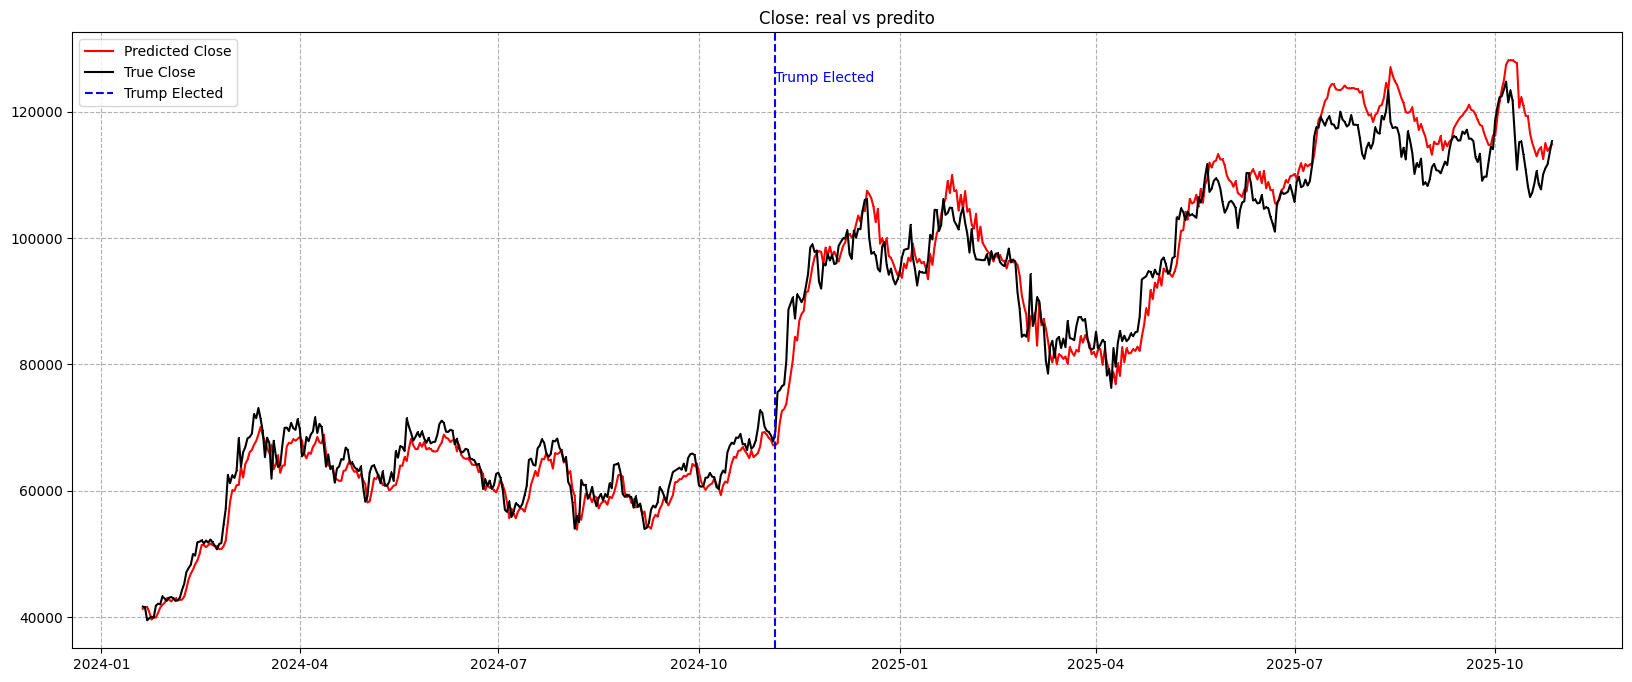

In [149]:

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

5 de novembro donald trump foi eleito presidente

### Modelo com dado completo com a tendencia das palavras

In [150]:
data = pd.read_csv('../data/processed/BTC-USD_crypto_all.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume,crypto,bitcoin
Date,,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,6,48
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,7,51
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,5,56
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,4,49
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,4,50


In [151]:
X_mult = data[['High', 'Low', 'Open', 'Volume', 'crypto']]
y_mult = data[['Close']]

In [152]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult.values, y_mult.values, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_raw, X_test_raw = X_seq[:train_size], X_seq[train_size:]
  y_train_raw, y_test_raw = y_seq[:train_size], y_seq[train_size:]

  scaler_X_crypto_all = MinMaxScaler(feature_range=(0, 1))
  scaler_y_crypto_all = MinMaxScaler(feature_range=(0, 1))

  # O X é 3D (samples, timesteps, features), então precisamos achatar para escalar
  X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2])
  X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])

  scaler_X_crypto_all.fit(X_train_reshaped)
  X_train_scaled = scaler_X_crypto_all.transform(X_train_reshaped).reshape(X_train_raw.shape)
  X_test_scaled = scaler_X_crypto_all.transform(X_test_reshaped).reshape(X_test_raw.shape)

  scaler_y_crypto_all.fit(y_train_raw)     
  y_train_scaled = scaler_y_crypto_all.transform(y_train_raw)
  y_test_scaled = scaler_y_crypto_all.transform(y_test_raw)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_crypto_all = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_crypto_all.append({
      "model": grid_result_crypto_all.best_estimator_,
      "params": grid_result_crypto_all.best_params_,
      "rmse": -grid_result_crypto_all.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Multivariado",
      "algorithm": "LSTM",
      "scaler_X": scaler_X_crypto_all,
      "scaler_y": scaler_y_crypto_all
    })
    
    print(f"Menor RMSE: {-grid_result_crypto_all.best_score_:.3f} usando: {grid_result_crypto_all.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.022 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 40, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.020 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.033 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.035 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}


#### Resultados

In [162]:

for m in models_lstm_crypto_all:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_crypto_ordered_by_test = sorted(models_lstm_crypto_all, key=lambda x: x["rmse_test"])
lstm_crypto_ordered_by_test

[{'model': KerasRegressor(
  	model=<function create_lstm_model at 0x000001BA1C852AC0>
  	build_fn=None
  	warm_start=False
  	random_state=None
  	optimizer=rmsprop
  	loss=None
  	metrics=None
  	batch_size=None
  	validation_batch_size=None
  	verbose=0
  	callbacks=None
  	validation_split=0.0
  	shuffle=True
  	run_eagerly=False
  	epochs=1
  	seq_len=7
  	n_features=5
  	fit__batch_size=16
  	fit__epochs=100
  	model__drop=0.1
  	model__neurons=60
  	model__optimizer=Adam
  ),
  'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.1,
   'model__neurons': 60,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.020421353544280534),
  'n_splits': 10,
  'seq_len': 7,
  'X_test': array([[[0.42964284, 0.43022619, 0.43124169, 0.05204688, 0.40425532],
          [0.43419629, 0.43459839, 0.43826638, 0.05472598, 0.38297872],
          [0.42526789, 0.43479441, 0.43021664, 0.03639836, 0.38297872],
          ...,
          [0.42128348, 0.43476887, 0.42893387, 0.01878

In [163]:
y_pred_scaled = lstm_crypto_ordered_by_test[0]["model"].predict(lstm_crypto_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_crypto_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_crypto_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = lstm_crypto_ordered_by_test[0]["scaler_y"].inverse_transform(y_pred_scaled)
y_test = lstm_crypto_ordered_by_test[0]["scaler_y"].inverse_transform(lstm_crypto_ordered_by_test[0]["y_test"])

MAE normalizado: 0.061749230272489
RMSE normalizado: 0.09052188140897821


In [164]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 4161.203317663379
RMSE real: 6100.15605635263
MAPE: 4.65%
R²: 0.95


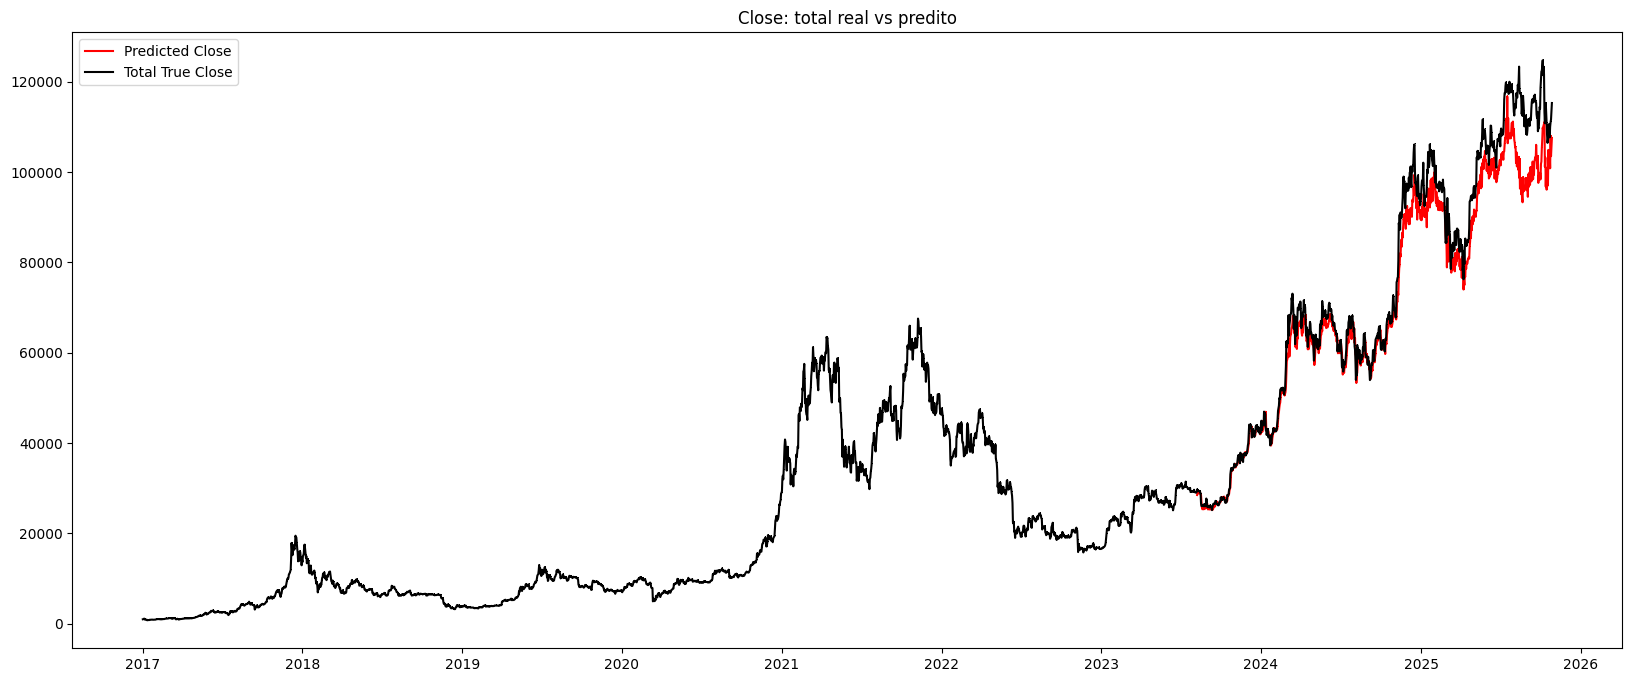

In [165]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

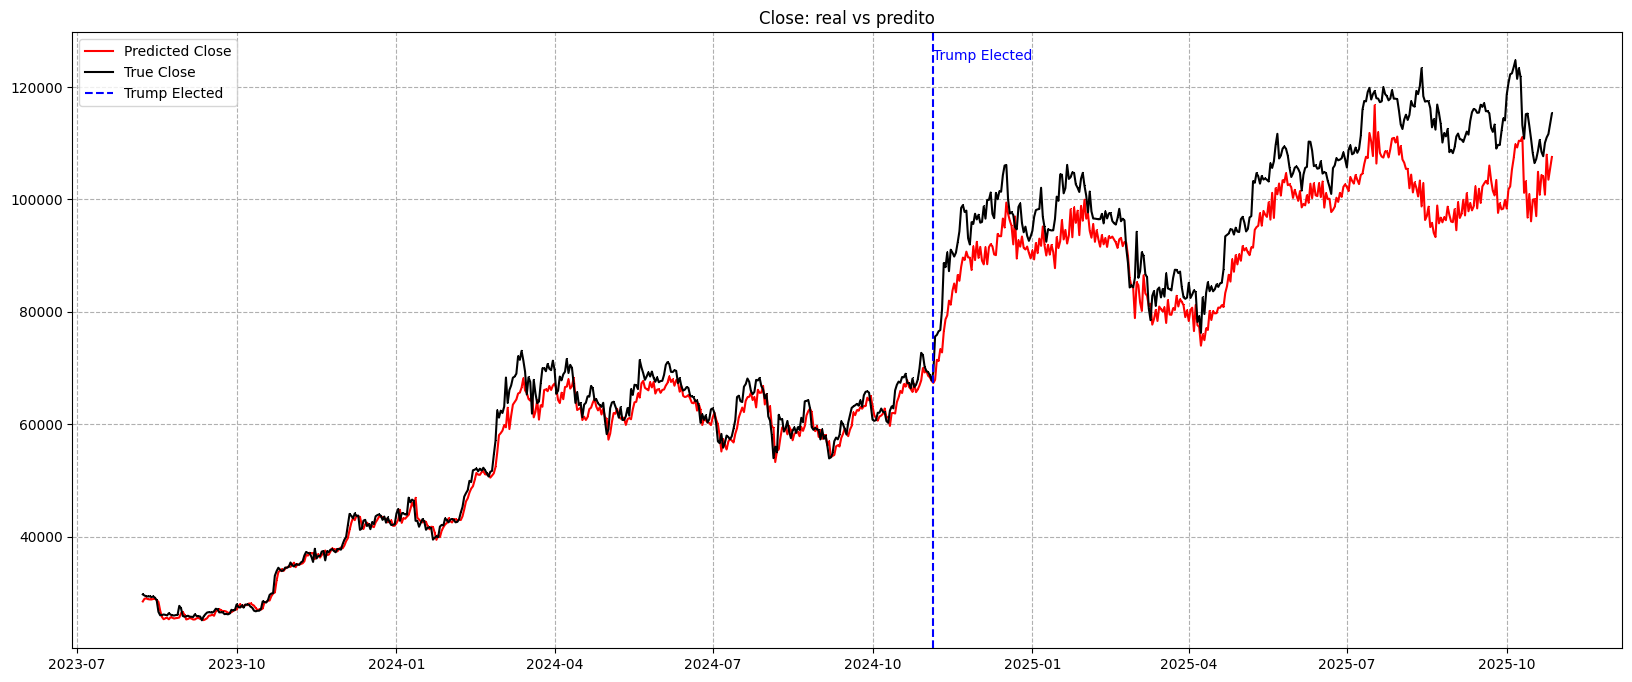

In [166]:

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

### Modelo dado cortado com tendencia da palavra "crypto"

In [8]:
data = pd.read_csv('../data/processed/BTC-USD_crypto_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume,crypto,bitcoin
Date,,,,,,,
2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008,3,41
2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992,3,78
2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000,3,70
2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984,3,82
2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008,4,100


In [9]:
X_mult = data[['High', 'Low', 'Open', 'Volume', 'crypto']]
y_mult = data[['Close']]

In [14]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult.values, y_mult.values, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_raw, X_test_raw = X_seq[:train_size], X_seq[train_size:]
  y_train_raw, y_test_raw = y_seq[:train_size], y_seq[train_size:]

  scaler_X_crypto_cropped = MinMaxScaler(feature_range=(0, 1))
  scaler_y_crypto_cropped = MinMaxScaler(feature_range=(0, 1))

  # O X é 3D (samples, timesteps, features), então precisamos achatar para escalar
  X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2])
  X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])

  scaler_X_crypto_cropped.fit(X_train_reshaped)
  X_train_scaled = scaler_X_crypto_cropped.transform(X_train_reshaped).reshape(X_train_raw.shape)
  X_test_scaled = scaler_X_crypto_cropped.transform(X_test_reshaped).reshape(X_test_raw.shape)

  scaler_y_crypto_cropped.fit(y_train_raw)     
  y_train_scaled = scaler_y_crypto_cropped.transform(y_train_raw)
  y_test_scaled = scaler_y_crypto_cropped.transform(y_test_raw)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_crypto_cropped = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_crypto_cropped.append({
      "model": grid_result_crypto_cropped.best_estimator_,
      "params": grid_result_crypto_cropped.best_params_,
      "rmse": -grid_result_crypto_cropped.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Multivariado",
      "algorithm": "LSTM",
      "scaler_X": scaler_X_crypto_cropped,
      "scaler_y": scaler_y_crypto_cropped
    })
    
    print(f"Menor RMSE: {-grid_result_crypto_cropped.best_score_:.3f} usando: {grid_result_crypto_cropped.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.032 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.029 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.036 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.034 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}


#### Resultados

In [15]:

for m in models_lstm_crypto_cropped:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_crypto_cropped_ordered_by_test = sorted(models_lstm_crypto_cropped, key=lambda x: x["rmse_test"])
lstm_crypto_cropped_ordered_by_test

[{'model': KerasRegressor(
  	model=<function create_lstm_model at 0x00000196801E14E0>
  	build_fn=None
  	warm_start=False
  	random_state=None
  	optimizer=rmsprop
  	loss=None
  	metrics=None
  	batch_size=None
  	validation_batch_size=None
  	verbose=0
  	callbacks=None
  	validation_split=0.0
  	shuffle=True
  	run_eagerly=False
  	epochs=1
  	seq_len=30
  	n_features=5
  	fit__batch_size=16
  	fit__epochs=100
  	model__drop=0.1
  	model__neurons=60
  	model__optimizer=Adam
  ),
  'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.1,
   'model__neurons': 60,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.03588901984319913),
  'n_splits': 5,
  'seq_len': 30,
  'X_test': array([[[0.63239374, 0.63332522, 0.63936061, 0.06534847, 0.29787234],
          [0.62238206, 0.61969519, 0.62657798, 0.07392033, 0.27659574],
          [0.61443402, 0.62170908, 0.61874729, 0.04546239, 0.23404255],
          ...,
          [0.58353136, 0.59051077, 0.58558855, 0.06354

In [16]:
y_pred_scaled = lstm_crypto_cropped_ordered_by_test[0]["model"].predict(lstm_crypto_cropped_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_crypto_cropped_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_crypto_cropped_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = lstm_crypto_cropped_ordered_by_test[0]["scaler_y"].inverse_transform(y_pred_scaled)
y_test = lstm_crypto_cropped_ordered_by_test[0]["scaler_y"].inverse_transform(lstm_crypto_cropped_ordered_by_test[0]["y_test"])

MAE normalizado: 0.081469094172813
RMSE normalizado: 0.10854123253323467


In [17]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 5428.231495745305
RMSE real: 7232.02965869463
MAPE: 5.60%
R²: 0.89


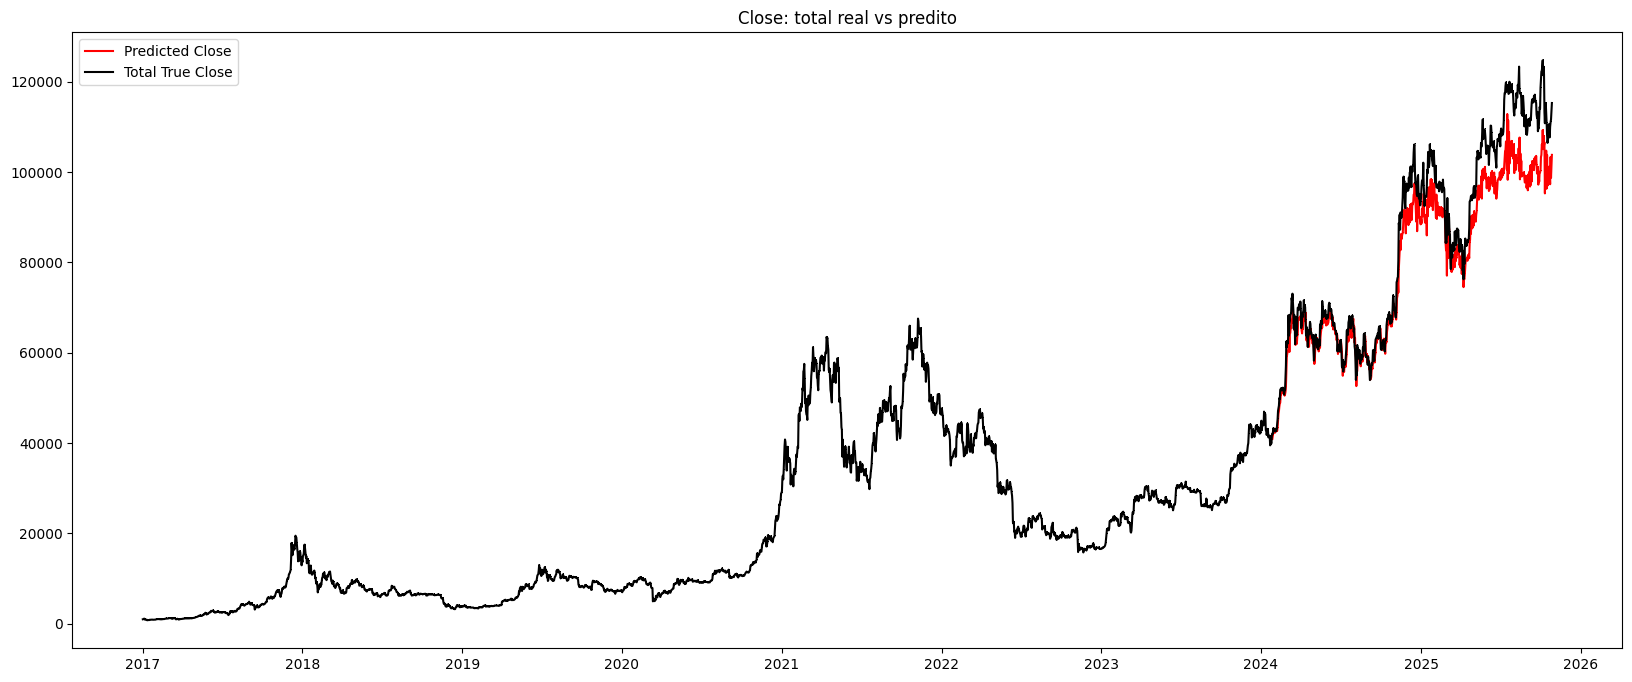

In [18]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

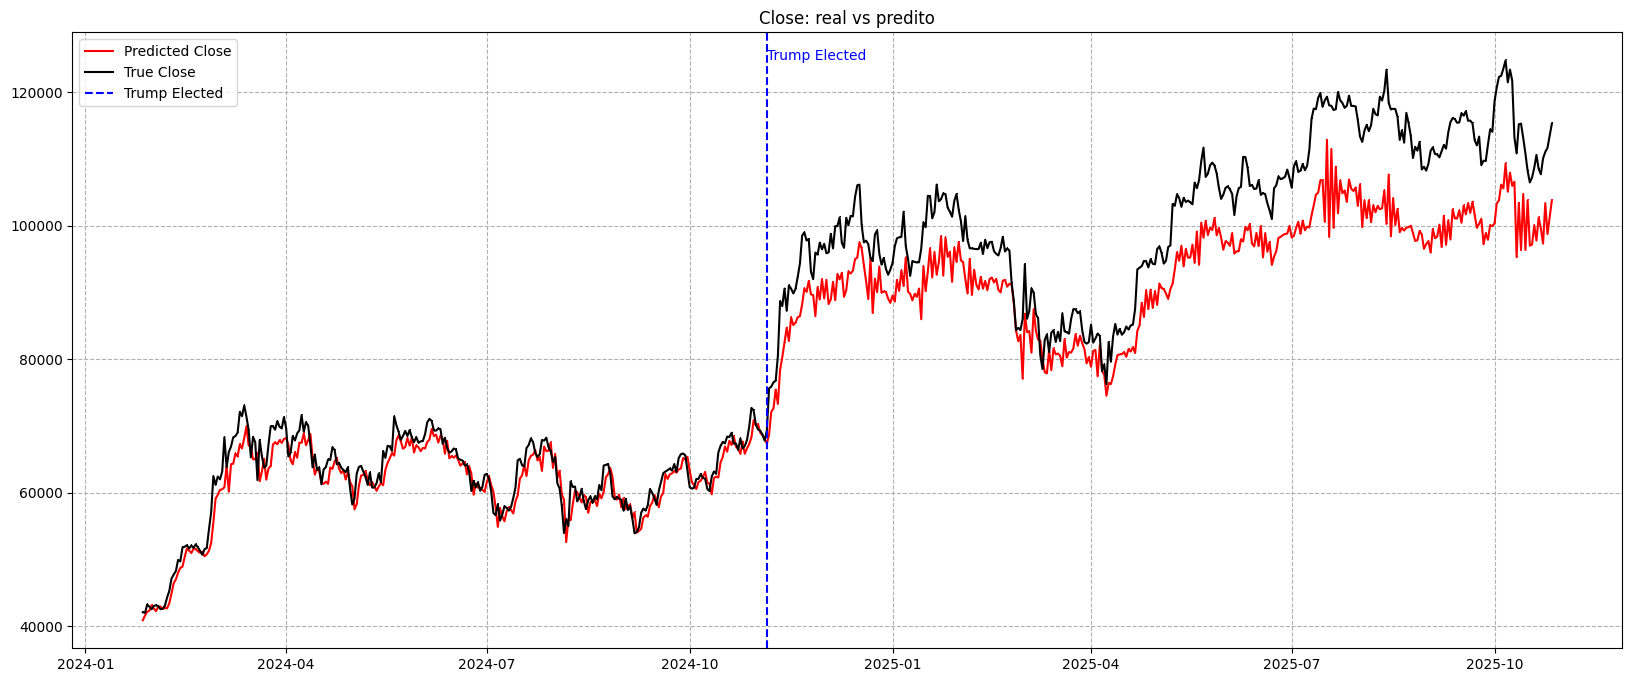

In [19]:

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()